# Diffusion model

In [61]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, model_utils, diffusion, diffusion_utils

# extras
# import einops
# import imageio
from tqdm.auto import tqdm


# needs to be refactored to src/data -> have to work with abstraction
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader


%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.diffusion, pmldiku.diffusion_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 4
device_name = "cuda" if cuda else "cpu"

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 

In [56]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)

loader = data.load_mnist(train=True, trans=transform).setup_data_loader(batch_size=batch_size, **kwargs)

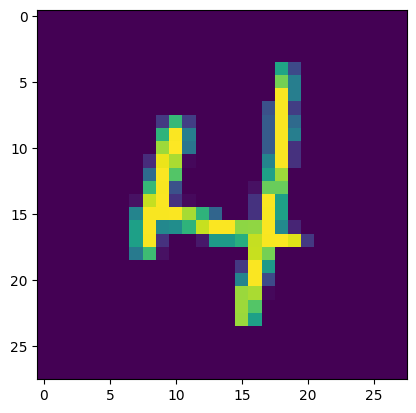

In [57]:
# see single image
plt.imshow(next(iter(loader))[0][0].squeeze().numpy())
plt.show()

In [58]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

# Refactor

In [59]:
# Construct model from params
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
config = diffusion.ParamConfig(n_steps, min_beta, max_beta)
model = diffusion.LightningDiffusion(config=config)

In [60]:
# from pytorch_lightning.callbacks import TQDMProgressBar
# callbacks = [TQDMProgressBar()]
trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name)
trainer.fit(model=model, train_dataloaders=loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name             | Type            | Params
-----------------------------------------------------
0 | diffusion_params | DiffusionParams | 0     
1 | network          | MyUNet          | 606 K 
2 | diffusion        | Diffusion       | 606 K 
-----------------------------------------------------
506 K     Trainable params
100 K     Non-trainable params
606 K     Total params
2.427     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Setting diffusion params to: cuda:0


`Trainer.fit` stopped: `max_epochs=4` reached.


## Plot

In [75]:
generated = diffusion_utils.generate_new_images(
        model,
        n_samples=100,
        device=device
    )

cuda:0 cuda:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

In [ ]:
diffusion_utils.show_images(generated, "Final result")